# Compare the amplitude with the KdV solution

In [1]:
# from soda.dataio import netcdfio
# from soda.dataio.conversion import readotps
from sfoda.utils.othertime import SecondsSince

from datetime import datetime
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import h5py
# import seaborn as sns

import matplotlib.dates as mdates

In [2]:
%matplotlib inline

In [21]:
!ls ../output/*v2*.nc

../output/2021-04-06--23-57-18_slim-stoch_a0_data_rho_v2_magnus_kdv_runs.nc
../output/2021-04-07--05-25-38_slim-stoch_a0_clim_rho_v2_magnus_kdv_runs.nc
../output/2021-04-07--05-26-47_slim-harmo_a0_data_rho_v2_magnus_kdv_runs.nc
../output/2021-04-07--05-27-46_slim-harmo_a0_clim_rho_v2_magnus_kdv_runs.nc


In [90]:
# Load the KdV solution

# vkdvfile = '../output/2021-04-07--05-27-46_slim-harmo_a0_clim_rho_v2_magnus_kdv_runs.nc'
# sitename = 'harmo_a0_clim_rho_v2'

# vkdvfile = '../output/2021-04-07--05-26-47_slim-harmo_a0_data_rho_v2_magnus_kdv_runs.nc'
# sitename = 'harmo_a0_data_rho'

vkdvfile = '../output/2021-04-07--05-25-38_slim-stoch_a0_clim_rho_v2_magnus_kdv_runs.nc'
sitename = 'stoch_a0_clim_rho'

# vkdvfile = '../output/2021-04-06--23-57-18_slim-stoch_a0_data_rho_v2_magnus_kdv_runs.nc'
# sitename = 'stoch_a0_data_rho'

# This is just to get the time variables... :(
betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_20162017_prediction_v4.h5'

#dskdv = xr.open_dataset('../output/2021-03-28--11-54-46_slim-AR_a0_harmonic_beta_magnus_kdv_runs.nc')
# # dskdv = xr.open_dataset('../output/2020-10-30--01-59-53_slim-harmonic_beta_band6_a0_bugfix_magnus_kdv_runs.nc')
#betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'

# a0file = '../inputs/a0_samples_harmonicfit_M2S2N2lowfreq_12month.h5'
# a0file = '../inputs/a0_samples_harmonicfit_M2S2nonstat_N2K1O1_12month.h5'
# sitename = 'harmonic_beta_a0_nonstat_6h_bugfix'

# dskdv = xr.open_dataset('../output/2019-11-12--00-42-28_slim-harmonic_beta_pred_a0_magnus_kdv_runs.nc')
# betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'
# a0file = '../inputs/a0_samples_harmonicfit_M2S2nonstat_N2K1O1_12month.h5'
# sitename = 'harmonic_beta_a0_20162017'

# dskdv = xr.open_dataset('../output/2019-11-27--00-32-41_slim-harmonic_beta_band3_a0_magnus_kdv_runs.nc')
# betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'
# a0file = '../inputs/a0_samples_bandpass_3h_12month.h5'
# sitename = 'harmonic_beta_a0_bandpass_3h'

# dskdv = xr.open_dataset('../output/2019-11-27--00-34-06_slim-harmonic_beta_band6_a0_magnus_kdv_runs.nc')
# betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'
# a0file = '../inputs/a0_samples_bandpass_6h_12month.h5'
# sitename = 'harmonic_beta_a0_bandpass_6h'

In [91]:
dskdv = xr.open_dataset(vkdvfile)

# # Create a time series of single days with the max amplitude 
# time1 = pd.date_range('2016-5-1','2016-9-15',freq='12.5H') 
# time2 = pd.date_range('2016-11-1','2017-5-1',freq='12.5H')
# timemax = time1.append(time2)

# dskdv = dskdv.sel(time=range(0,367))
dskdv

<xarray.Dataset>
Dimensions:    (ensemble: 500, params: 6, time: 367)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365 366
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params     (params) int64 0 1 2 3 4 5
Data variables:
    amax       (ensemble, time) float64 ...
    tmax       (ensemble, time) float64 ...
    a0         (ensemble, time) float64 ...
    cn         (ensemble, time) float64 ...
    alpha      (ensemble, time) float64 ...
    alpha2     (ensemble, time) float64 ...
    cn_mu      (ensemble, time) float64 ...
    alpha_mu   (ensemble, time) float64 ...
    alpha2_mu  (ensemble, time) float64 ...
    beta       (time, ensemble, params) float64 ...
    ubed       (ensemble, time) float64 ...
    usurf      (ensemble, time) float64 ...

In [92]:
badidx = dskdv.amax==-999.
dskdv.amax.values[badidx] = np.nan
dskdv.ubed.values[badidx] = np.nan
dskdv.a0.values[badidx] = np.nan
dskdv.cn_mu.values[badidx] = np.nan
dskdv.alpha_mu.values[badidx] = np.nan
dskdv.cn.values[badidx] = np.nan
dskdv.alpha.values[badidx] = np.nan

# dskdv.where(dskdv.amax!=-999)

In [93]:
# Get the time from the input beta file

timedays = dskdv.time
nt = timedays.shape[0]

# Get the time from the beta file
with h5py.File(betafile,'r') as f:
    t=f['data/time'][:].astype('<M8[ns]')

# Add on a 1-day offset??
time = t[:nt] +  np.timedelta64(1,'D')


time.shape, t.shape, nt

((367,), (367,), 367)

In [94]:
# update the time
dskdv['time'] = time
#dskdv['time'] = dskdv['time'].astype('<M8[ns]')
#dskdv['time']
dskdv

<xarray.Dataset>
Dimensions:    (ensemble: 500, params: 6, time: 367)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-02 2016-05-03 ... 2017-05-03
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params     (params) int64 0 1 2 3 4 5
Data variables:
    amax       (ensemble, time) float64 nan nan 17.87 9.517 ... 0.0 0.0 0.0
    tmax       (ensemble, time) float64 ...
    a0         (ensemble, time) float64 nan nan 14.91 10.87 ... 0.0 0.0 0.0
    cn         (ensemble, time) float64 nan nan 1.204 1.206 ... 0.0 0.0 0.0
    alpha      (ensemble, time) float64 nan nan -0.003492 ... 0.0 0.0 0.0
    alpha2     (ensemble, time) float64 ...
    cn_mu      (ensemble, time) float64 nan nan 1.446 1.41 ... 1.434 0.0 0.0 0.0
    alpha_mu   (ensemble, time) float64 nan nan -0.009462 ... 0.0 0.0 0.0
    alpha2_mu  (ensemble, time) float64 ...
    beta       (time, ensemble, params) float64 ...
    ubed       (ensemble, time) float64 nan nan 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    usurf      (ensemble, time) float64 ...

In [95]:
# Validate the amplitude also...
###########
#basedir = 'C:\Projects\ARCHub\DATA\FIELD\ShellCrux\'

# basedir = '/home/mrayson/group/mrayson/DATA/FIELD/ShellCrux/'
ncfile = '/home/suntans/Projects/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
# ncfile = '{}/KP150_Fitted_Buoyancy_wout_motion_unvenfilt.nc'.format(basedir)

mode = 0
###########

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two

A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan


In [96]:
def min_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    
def maximum_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    amp_max = np.nanmax(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

In [97]:
# Find the A_max over one day blocks
# Create a time series of single days with the max amplitude 
time1 = pd.date_range('2016-5-1','2016-9-15',freq='12.5H') 
time2 = pd.date_range('2016-11-1','2017-5-1',freq='12.5H')
timemax = time1.append(time2)

Amax_all = []
Amax_time = []
for t1,t2 in zip(timemax[0:-1],timemax[1::]):
    #t2 = t1 + np.timedelta64(1,'D')
    
    #Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    Amax, tidx = min_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)

    tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))

# plt.figure()
# A_n.plot(lw=0.2)
# plt.plot(ds_A['time'], ds_A.values,'k.')

In [99]:
# Count the number of points within each credible interval

# Interplate p95 and p5 onto the observation points

def calc_credint(credint):

    lowval = (100-credint)/2
    highval = 100-(100-credint)/2 

    amax_min = np.nanpercentile(dskdv.amax,lowval, axis=0)
    amax_max = np.nanpercentile(dskdv.amax,highval, axis=0)

    tsec = SecondsSince(time)
    tsec_i = SecondsSince(ds_A['time'].values)

    Fmax = interp1d(tsec, amax_max, bounds_error=False)
    Fmin = interp1d(tsec, amax_min, bounds_error=False)

    amax_min_i = Fmin(tsec_i)
    amax_max_i = Fmax(tsec_i)

    idx_in = (ds_A.values > amax_min_i) & (ds_A.values < amax_max_i)

    nt = tsec_i.shape[0]
    #, lowval, highval
    return np.sum(idx_in)/nt * 100, idx_in

In [100]:
# Count the number of large amplitude wave events within the credible interval
bigwave_thresh = -35
idx = ds_A.values < bigwave_thresh
nlarge = np.sum(idx)

#idx_in = (ds_A.values[idx] > amax_min_i[idx]) & (ds_A.values[idx] < amax_max_i[idx])
pp,idx_in = calc_credint(90)
np.sum(idx_in), nlarge

# Calculate the probability
idx_kdv  = dskdv.amax.values < bigwave_thresh
plarge = idx_kdv.sum(axis=0)/500 * 100

tsec = SecondsSince(time)
tsec_i = SecondsSince(ds_A['time'].values)

Fmax = interp1d(tsec, plarge, bounds_error=False)

plarge_i = Fmax(tsec_i)
    


# Count:
 
 - Number of times obs exceeds the threshold
 - Number of times obs and model exceed 40 m together
 - Number of times model exceeds 40 m but obs. does not
 - Number of times obs. exceeds 40 m but models does not

In [101]:
print('No. obs > thresh = {}'.format(idx.sum()))
print('No. mod > thresh = {}'.format((plarge_i>5).sum()))
print('No. (mod AND obs) > thresh = {}'.format(( (plarge_i>5) & (idx)).sum()))
print('No. mod > thresh but not obs = {}'.format(( (plarge_i>5) & (~idx)).sum()))
print('No. obs > thresh but not mod = {}'.format(idx.sum() - ( (plarge_i>5) & (idx)).sum()))




No. obs > thresh = 40
No. mod > thresh = 69
No. (mod AND obs) > thresh = 2
No. mod > thresh but not obs = 67
No. obs > thresh but not mod = 38


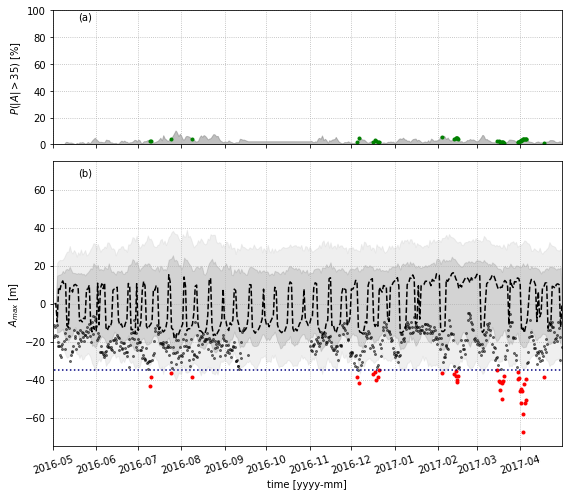

stoch_a0_clim_rho


<Figure size 432x288 with 0 Axes>

In [104]:
amax_min = np.nanpercentile(dskdv.amax,5, axis=0)
amax_max = np.nanpercentile(dskdv.amax,95, axis=0)
amax_low = np.nanpercentile(dskdv.amax,25, axis=0)
amax_high = np.nanpercentile(dskdv.amax,75, axis=0)
# amax_amin = np.min(dskdv.amax, axis=0)
# amax_amax = np.max(dskdv.amax, axis=0)
amax_50 = np.nanmedian(dskdv.amax, axis=0)

xlim = [timemax[0],timemax[-1]]

plt.figure(figsize=(8,7))
ax1=plt.subplot2grid((3,1),(0,0),rowspan=1,)

plt.fill_between(ds_A['time'].values,plarge_i,color='0.5', alpha=0.5)
# plt.plot(ds_A['time'].values[plarge_i>1],plarge_i[plarge_i>1],'r.')
plt.plot(ds_A['time'].values[idx],plarge_i[idx],'g.')
plt.ylim(0,100)
plt.grid(b=True, linestyle=':')
plt.ylabel('$P(|A|>35)$ [%]')

plt.xlim(xlim)
ax1.set_xticklabels([])
plt.text(0.05,0.93,'(a)',transform=ax1.transAxes)

# ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
# A_n.plot(lw=0.2)
# plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)
# plt.plot(ta0, a0_samples.mean(axis=1),'m--')
# plt.fill_between(ta0, np.percentile(a0_samples,2.5,axis=1),
#          np.percentile(a0_samples,97.5,axis=1), color='m',alpha=0.5    )

# ax1.set_xticklabels([])
# plt.xlabel('')
# plt.grid(b=True)
# plt.ylabel('$A$ [m]')
# plt.ylim(-75,75)
# plt.title('')
# plt.xlim(xlim)
# plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)
# ax1.set_xticklabels([])

ax2=plt.subplot2grid((3,1),(1,0),rowspan=2,)
# ax2=plt.gca()
plt.fill_between(time, amax_min, amax_max, color='0.7',alpha=0.2)
# plt.fill_between(time, amax_min, amax_max, color='0.3',alpha=0.2)
plt.fill_between(time, amax_low, amax_high, color='0.4',alpha=0.2)

plt.plot(time,amax_50,'k--', lw=1.5)
#plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

plt.plot(ds_A['time'][idx], ds_A.values[idx],'ro', ms=3,)
plt.plot(ds_A['time'][idx_in & idx], ds_A.values[idx_in & idx],'g*', ms=5, )

plt.plot([ds_A['time'].values[0],ds_A['time'].values[-1]],[bigwave_thresh,bigwave_thresh],'navy',ls=':')


# plot the good and bad predictions


# plt.plot(time, a0_samples.mean(axis=1),'m--')
# plt.fill_between(time, np.percentile(a0_samples,2.5,axis=1),
#          np.percentile(a0_samples,97.5,axis=1), color='m',alpha=0.5    )

#plt.xlim(200,300)
plt.ylabel('$A_{max}$ [m]')
plt.ylim(-75,75)
#plt.xlabel('time [days]')
plt.grid(b=True)
#plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)
plt.xlim(xlim)
plt.xlabel('time [yyyy-mm]')
plt.grid(b=True, ls=':')

plt.xticks(rotation=17)
plt.text(0.05,0.95,'(b)',transform=ax2.transAxes)

plt.tight_layout()
plt.show()
plt.savefig('../FIGURES/kdv_12month_Amax_validation_{}.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/kdv_12month_Amax_validation_{}.pdf'.format(sitename),dpi=150)
print(sitename)

NameError: name 'ta0' is not defined

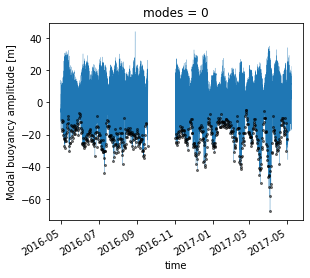

In [89]:


def plot_timeseg(xlim):
    # ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
    A_n.plot(lw=0.2)
    plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

    plt.plot(ta0, a0_samples.mean(axis=1),'m--')
    plt.fill_between(ta0, np.percentile(a0_samples,5,axis=1),
             np.percentile(a0_samples,95,axis=1), color='m',alpha=0.5    )

    # ax1.set_xticklabels([])
    # plt.xlabel('')
    # plt.grid(b=True)
    # plt.ylabel('$A$ [m]')
    # plt.ylim(-75,75)
    # plt.title('')
    # plt.xlim(xlim)
    # plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)


    # ax2=plt.subplot2grid((4,1),(2,0),rowspan=2)
    # plt.fill_between(time, amax_amin, amax_amax, color='0.5',alpha=0.2)
    plt.fill_between(time, amax_mset_xticklabelscolor='0.7',alpha=0.2)
    plt.fill_between(time, amax_low, amax_high, color='0.2',alpha=0.2)

    plt.plot(time,amax_50,'k--', lw=1.5)
    #plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
    plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

    plt.plot(ds_A['time'][idx], ds_A.values[idx],'ro', ms=3,)
    plt.plot(ds_A['time'][idx&idx_in], ds_A.values[idx&idx_in],'g*', ms=5, )

    plt.plot([ds_A['time'].values[0],ds_A['time'].values[-1]],[bigwave_thresh,bigwave_thresh],'navy',ls=':')

    # plt.legend(('$A(t)$','$A_{max}$','$a_0(t)$ - median','$A_{max}$ - median','$A_{max}$ - 95%'
    #            ))
    #plt.xlim(200,300)
    plt.ylabel('$A$ [m]')
    plt.ylim(-75,75)
    #plt.xlabel('time [days]')
    plt.grid(b=True)
    #plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)
    plt.xlim(xlim)
    #plt.xlabel('time [yyyy-mm]')
    plt.grid(b=True)
    #plt.xlim(time[0],time[-1])
    plt.xticks(rotation=17)
    # plt.text(0.05,0.9,'(b)',transform=ax2.transAxes)
    plt.title('')
    plt.tight_layout()
    plt.show()
    


plt.figure(figsize=(10,8))
ax = plt.subplot(221)
xlim = [datetime(2016,11,11),datetime(2016,11,26)]
plot_timeseg(xlim)
plt.xlabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))     #optional formatting 
plt.xticks(rotation=0)
ax.text(0.02,1.02,'(a)', transform=ax.transAxes)


ax = plt.subplot(222)
xlim = [datetime(2016,12,11),datetime(2016,12,26)]
plot_timeseg(xlim)
plt.ylabel('')
ax.set_yticklabels([])
plt.xlabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))     #optional formatting 
plt.xticks(rotation=0)
ax.text(0.02,1.02,'(b)', transform=ax.transAxes)

ax = plt.subplot(223)
xlim = [datetime(2017,2,25),datetime(2017,3,9)]
plot_timeseg(xlim)
plt.xlabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))     #optional formatting 
plt.xticks(rotation=0)
ax.text(0.02,1.02,'(c)', transform=ax.transAxes)


ax = plt.subplot(224)
xlim = [datetime(2017,3,25),datetime(2017,4,9)]
plot_timeseg(xlim)
plt.ylabel('')
ax.set_yticklabels([])
plt.xlabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))     #optional formatting 
plt.xticks(rotation=0)
ax.text(0.02,1.02,'(d)', transform=ax.transAxes)

plt.tight_layout()


plt.savefig('../FIGURES/kdv_12month_Amax_validation_zoom_eg.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/kdv_12month_Amax_validation_zoom_eg.pdf'.format(sitename),dpi=150)

In [22]:
# Plot distributions of the input and output

# Locate the time index
t1new = '2016-07-23'
t2new = '2017-04-03'
# ds_A_t1 = dskdv.sel(time=np.datetime64(t1new,'ns').astype(int), method='nearest')
# ds_A_t2 = dskdv.sel(time=np.datetime64(t2new,'ns').astype(int), method='nearest')
ds_A_t1 = dskdv.sel(time=np.datetime64(t1new,'ns'), method='nearest')
ds_A_t2 = dskdv.sel(time=np.datetime64(t2new,'ns'), method='nearest')

#ds_A_t1

<IPython.core.display.Javascript object>


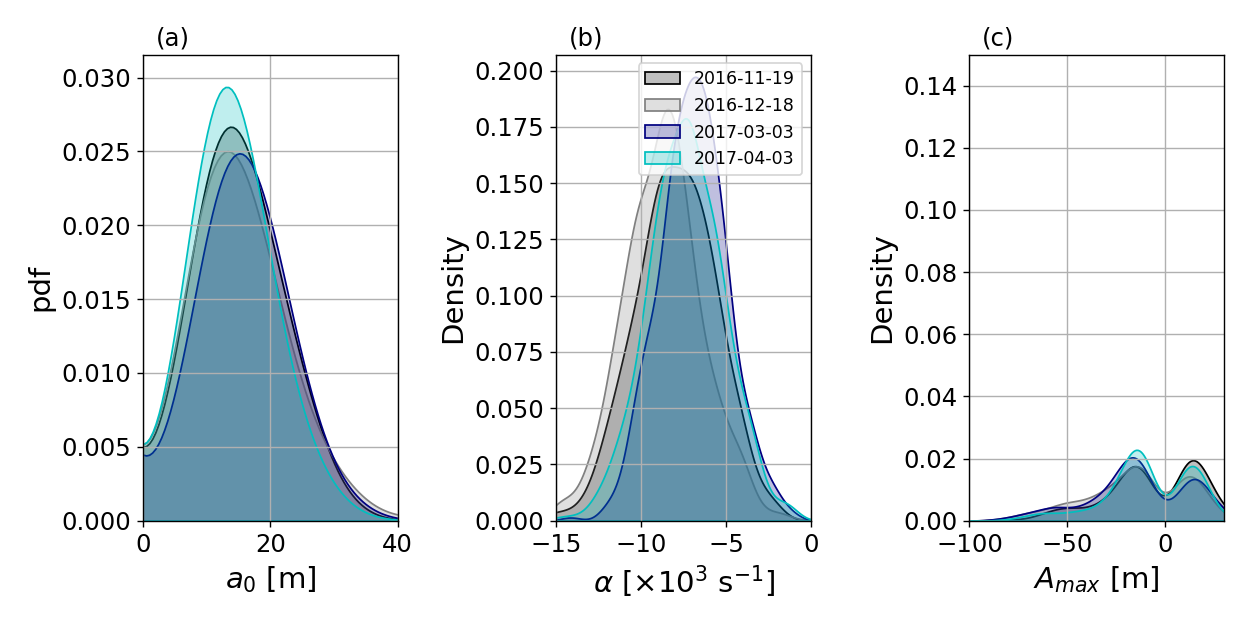

In [23]:
# Locate the time index
t1new = '2016-11-19'
t2new = '2016-12-18'
t3new = '2017-03-03'
t4new = '2017-04-03'



ds_A_t1 = dskdv.sel(time=np.datetime64(t1new,'ns'), method='nearest')
ds_A_t2 = dskdv.sel(time=np.datetime64(t2new,'ns'), method='nearest')
ds_A_t3 = dskdv.sel(time=np.datetime64(t3new,'ns'), method='nearest')
ds_A_t4 = dskdv.sel(time=np.datetime64(t4new,'ns'), method='nearest')


good1 = ~np.isnan(ds_A_t1.amax)


plt.figure(figsize=(10,5))
ax=plt.subplot(131)


sns.kdeplot(ds_A_t1.a0, color='k',shade=True, legend=False)
sns.kdeplot(ds_A_t2.a0, color='0.5',shade=True, legend=False)
sns.kdeplot(ds_A_t3.a0, color='navy',shade=True, legend=False)
sns.kdeplot(ds_A_t4.a0, color='c',shade=True, legend=False)

# sns.kdeplot(ds_A_t1.alpha*1e3, color='k',shade=True, legend=False)
# sns.kdeplot(ds_A_t2.alpha*1e3, color='0.5',shade=True, legend=False)

plt.xlabel('$a_0$ [m]')

plt.ylabel('pdf')
#plt.legend(('mean %s'%t1new,'mean %s'%t2new,t1new,t2new))
# plt.legend((t1new,t2new))
plt.xlim(0,40)

plt.grid(b=True)
ax.text(0.05,1.02, '(a)', transform=ax.transAxes)


# ax=plt.subplot(222)

# # sns.kdeplot(ds_A_t1.cn, color='k',shade=True, legend=False)
# # sns.kdeplot(ds_A_t2.cn, color='0.5',shade=True, legend=False)

# sns.kdeplot(ds_A_t1.cn_mu, color='k',shade=True, legend=False, ls='-')
# sns.kdeplot(ds_A_t2.cn_mu, color='0.5',shade=True, legend=False, ls='-')
# sns.kdeplot(ds_A_t3.cn_mu, color='navy',shade=True, legend=False, ls='-')

# plt.xlabel('$c$ [m s$^{-1}$]')
# plt.grid(b=True)
# ax.text(0.05,1.02, '(b)', transform=ax.transAxes)


ax=plt.subplot(132)
#plt.ylabel('pdf')

sns.kdeplot(ds_A_t1.alpha_mu*1e3, color='k',shade=True, legend=False, ls='-')
sns.kdeplot(ds_A_t2.alpha_mu*1e3, color='0.5',shade=True, legend=False, ls='-')
sns.kdeplot(ds_A_t3.alpha_mu*1e3, color='navy',shade=True, legend=False, ls='-')
sns.kdeplot(ds_A_t4.alpha_mu*1e3, color='c',shade=True, legend=False, ls='-')

plt.xlabel(r'$\alpha$ [$\times 10^3$ s$^{-1}$]')

plt.grid(b=True)
ax.text(0.05,1.02, '(b)', transform=ax.transAxes)
# ax.set_ylim(0,0.20)
plt.xlim(-15,0)
plt.legend((t1new,t2new,t3new, t4new), fontsize=10)

ax=plt.subplot(133)

sns.kdeplot(ds_A_t1.amax, color='k',shade=True, legend=False)
sns.kdeplot(ds_A_t2.amax, color='0.5',shade=True, legend=False)
sns.kdeplot(ds_A_t3.amax, color='navy',shade=True, legend=False)
sns.kdeplot(ds_A_t4.amax, color='c',shade=True, legend=False)

plt.xlim(-100,30)
plt.xlabel('$A_{max}$ [m]')
ax.text(0.05,1.02, '(c)', transform=ax.transAxes)
plt.grid(b=True)
#ax.set_yscale('log')
ax.set_ylim(0,0.15)

plt.tight_layout()

plt.savefig('../FIGURES/vkdv_posteriordist_%s.png'%t1new, dpi=150)
plt.savefig('../FIGURES/vkdv_posteriordist_%s.pdf'%t1new, dpi=300)